# Проведение и статистическая обработка А/В-теста.

Отдел маркетинга крупного интернет-магазина подготовил список гипотез для увеличения выручки и провёл А/В-тест одной из них.

# Задачи:

- приоритезирвать гипотезы, применив фреймворк ICE/RICE, и объяснить результат;
- проанализировать результат запущенного А/В-теста, принять аргументированное решение об остановке или продолжении теста.

# Описание данных:
Данные представлены тремя файлами.

Первый файл необходим для приоретизации гипотез и содержит краткое описание гипотезы, охват пользователей, влияние на пользователей, уверенность в гипотезе, затраты ресурсов на проверку гипотезы. Все параметры исчисляются по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для запуска А/В-теста и его обработки состоят из двух файлов с информацией о заказах пользователей (идентификатор заказа, идентификатор пользователя, дата и выручкой заказа,  группа A/B-теста, в которую попал заказ) и информацией о группах А/В-теста (дата, группа A/B-теста, количество пользователей в указанную дату в указанной группе A/B-теста).

## Загрузка данных

In [1]:
# Импортируем необходимые библиотеки:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import binom
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


# Сделаем графики более чёткими и читаемыми:
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 1

# Включим отображение всех столбцов для ознакомления с таблицами:
pd.set_option('display.max_column', None)

In [2]:
# считаем файлы и сохраним их в переменные аналогичные названиям файлов для удобства: 
try:
    hypothesis = pd.read_csv('.csv')
    orders = pd.read_csv('.csv')
    visitors = pd.read_csv('.csv')
except:
    hypothesis = pd.read_csv(r".csv")
    orders = pd.read_csv(r".csv")
    visitors = pd.read_csv(r".csv")

## Предварительная обработка данных

Проверим характеристики данных в таблицах.

Так как таблиц три, создадим функцию, которая в каждом случае выведет:

- начальные строки таблицы, чтобы соотнести записанные данные с дальнейшими характеристиками,
- техническую информацию о таблице, откуда мы получим представление о её размере, типах данных столбцов, наличии и размере количества пропусков,
- количество явных дубликатов.

In [3]:
def first_analyse(table):
    display(table.head()) # выведем часть таблицы
    print()
    table.info() # выведем техническую информацию о таблице
    print()
    print('Количество дубликатов: ', table.duplicated().sum()) # подсчистем и выведем количество дубликатов

In [4]:
first_analyse(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

Количество дубликатов:  0


Таблица не имеет дубликатов и пропусков, но названия столбцов следует изменить на удобный для python.

In [5]:
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

Проверим данные второй таблицы, содержащей характристики заказов.

In [6]:
first_analyse(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Количество дубликатов:  0


Таблица не имеет явных дубликатов и пропусков, но названия столбцов не удобны для работы на python, а тип даты заказа не соответствует datetime.

In [7]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [8]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
sorted(orders['date'].unique())

[numpy.datetime64('2019-08-01T00:00:00.000000000'),
 numpy.datetime64('2019-08-02T00:00:00.000000000'),
 numpy.datetime64('2019-08-03T00:00:00.000000000'),
 numpy.datetime64('2019-08-04T00:00:00.000000000'),
 numpy.datetime64('2019-08-05T00:00:00.000000000'),
 numpy.datetime64('2019-08-06T00:00:00.000000000'),
 numpy.datetime64('2019-08-07T00:00:00.000000000'),
 numpy.datetime64('2019-08-08T00:00:00.000000000'),
 numpy.datetime64('2019-08-09T00:00:00.000000000'),
 numpy.datetime64('2019-08-10T00:00:00.000000000'),
 numpy.datetime64('2019-08-11T00:00:00.000000000'),
 numpy.datetime64('2019-08-12T00:00:00.000000000'),
 numpy.datetime64('2019-08-13T00:00:00.000000000'),
 numpy.datetime64('2019-08-14T00:00:00.000000000'),
 numpy.datetime64('2019-08-15T00:00:00.000000000'),
 numpy.datetime64('2019-08-16T00:00:00.000000000'),
 numpy.datetime64('2019-08-17T00:00:00.000000000'),
 numpy.datetime64('2019-08-18T00:00:00.000000000'),
 numpy.datetime64('2019-08-19T00:00:00.000000000'),
 numpy.datet

Данные не имеют временного разраыва, что позволит избежать возможных ошибок. Рассмотрим наличие скрытых дубликатов по столбцу с id покупателей.

In [9]:
orders['visitor_id'].duplicated().sum()

166

In [10]:
orders[orders.duplicated('visitor_id')].sort_values(by='visitor_id')

,transaction_id,visitor_id,date,revenue,group
703,4293855558,8300375,2019-08-07,1790,A
823,2971973105,199603092,2019-08-27,2790,A
246,437656952,199603092,2019-08-02,3488,B
1102,1941707234,199603092,2019-08-12,6438,A
134,62794304,199603092,2019-08-22,6976,A
...,...,...,...,...,...
873,2519737434,4256040402,2019-08-08,58220,B
901,3402467119,4256040402,2019-08-27,1630,A
187,2048878902,4256040402,2019-08-17,1550,A
114,1120327437,4256040402,2019-08-01,5800,A


В данных о покупках выявлены постоянные покупатели, которые за время проведения теста совершили несколько покупок. Проверим таблицу на попадание таких пользователей в разные группы. 

In [11]:
users_in_groups = orders.groupby('visitor_id').agg({'group':'nunique'}).query('group>1').reset_index()

print('Количество клиентов, попавших в обе группы', len(users_in_groups), 'или', 
     round(100*len(users_in_groups)/len(orders['visitor_id'].unique())), '%')


Количество клиентов, попавших в обе группы 58 или 6 %


In [12]:
orders_in_two_groups = orders[orders['visitor_id'].isin(users_in_groups['visitor_id'])]

print('Сумма заказов, совершённых ошибочными клиентами', orders_in_two_groups['revenue'].sum(), 'руб или',
        round(100*orders_in_two_groups['revenue'].sum()/orders['revenue'].sum(), 2), '%'
    )
print('Количество заказов, совершённых ошибочными клиентами', orders_in_two_groups['revenue'].count(), 'или',
        round(100*len(orders_in_two_groups['revenue'])/len(orders['revenue']), 2), '%'
    )

Сумма заказов, совершённых ошибочными клиентами 1558935 руб или 15.6 %
Количество заказов, совершённых ошибочными клиентами 181 или 15.12 %


В обе группы попали 58 пользователей, что составляет 6% всего числа клиентов за месяц исследования. Эти ошибочные пользователи совершили 181 заказ (15% всего количества заказов) на более 1,5 млн рублей и скорее всего являются постоянными клиентами. Это большая сумма и существенная доля заказов, но в виду проводимого теста неизвестно, какая из исследуемых версий повлияла на их решения, что может сказаться на выявлении закономерностей и мешать однозначной интерпритации результатов. 

Однако удаление этих пользователей и их заказов так же может плохо повлиять на результаты, так как потеря данных будет весьма существенна. К тому же, тогда необходимо будет вручную удалить их данные из таблицы visitors, которая по дням характеризует количество участников групп теста.

Кроме того, необходимо проверить данные на аномалии, в результате очистки от которых таких перекрёстных постоянных клиентов станет меньше.

Исходя из вышеизложенного, данные пересекающихся в группах пользователей не следует исключать из исследования. Однако можно обратить внимание на этих пользователей и, если они являются постоянными клиентами, можно провести среди них анкетирование или опрос с оценкой проведённых измениений.

Рассмотрим последнюю таблицу на наличие технических ошибок.

In [13]:
first_analyse(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

Количество дубликатов:  0


В этой таблице так же следует изменить тип данных столбца даты, который при выгрузке данных оказался object.

In [14]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
sorted(visitors['date'].unique())

[numpy.datetime64('2019-08-01T00:00:00.000000000'),
 numpy.datetime64('2019-08-02T00:00:00.000000000'),
 numpy.datetime64('2019-08-03T00:00:00.000000000'),
 numpy.datetime64('2019-08-04T00:00:00.000000000'),
 numpy.datetime64('2019-08-05T00:00:00.000000000'),
 numpy.datetime64('2019-08-06T00:00:00.000000000'),
 numpy.datetime64('2019-08-07T00:00:00.000000000'),
 numpy.datetime64('2019-08-08T00:00:00.000000000'),
 numpy.datetime64('2019-08-09T00:00:00.000000000'),
 numpy.datetime64('2019-08-10T00:00:00.000000000'),
 numpy.datetime64('2019-08-11T00:00:00.000000000'),
 numpy.datetime64('2019-08-12T00:00:00.000000000'),
 numpy.datetime64('2019-08-13T00:00:00.000000000'),
 numpy.datetime64('2019-08-14T00:00:00.000000000'),
 numpy.datetime64('2019-08-15T00:00:00.000000000'),
 numpy.datetime64('2019-08-16T00:00:00.000000000'),
 numpy.datetime64('2019-08-17T00:00:00.000000000'),
 numpy.datetime64('2019-08-18T00:00:00.000000000'),
 numpy.datetime64('2019-08-19T00:00:00.000000000'),
 numpy.datet

Разрыва во временных данных нет, можно проводить анализ.

**Вывод**

На этапе предварительной обработки данных были выявлены и исправлены технические ошибки загрузки:

- в таблице гипотез названия столбцов были приведены к нижнему регистру;
- в таблице с данными о заказах были изменены названия столбцов и тип данных даты, обнаружены и оставлены без изменения данные постоянных покупателей с несколькими заказами;
- в таблице с данными о группах тестирования был изменён тип данных столбца даты;
- во всех таблица данные полные, без пропусков и дубликатов;
- в обе группы попали 58 пользователей (6% всего числа клиентов за месяц исследования), которые совершили 181 заказ (15% всего количества заказов) на более 1,5 млн рублей (15,6% выручки). Это существенные доли данных, поэтому их результаты были сохранены.

## Приоретизация гипотез

Ознакомимся с предложенными гипотезами и их характеристиками.

In [15]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В нашем распоряжении 9 гипотез, для которых оценены значения Reach, Impact, Confidence и Efforts, что позволит применить к ним фреймворки ICE и RICE. Добавим соответствующие столбцы в общую таблицу, вычислив значения по формулам, и выведем таблицу гипотез, отсортированную по убыванию значения RICE.

In [16]:
hypothesis['ICE'] = round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'], 3)
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

In [17]:
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.0


**Вывод**

Лидер по фреймворку RICE - гипотеза 7 ("Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") при подсчёте через фреймворк ICE занимет  лишь третью позицию, так как в этом случает не учитывает показатель охвата аудитории. Именно этот параметр существенно поднимет с пятого на второе место гипотезу 2 ("Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"), так как охват у этой гипотезы существенно шире - можно предположить, что рекомендации посмотрят почти все пользователи сайта. А вот гипотеза 8 о запуске акции, дающую скидку на товар в день рождения, которая хоть и затрагивает всех пользователей, но не сразу и это опускает её с лидирующей позиции при проверке ICE на пятое место в списке RICE.

Наименее приоритетны в обоих случаях проверки гипотезы об изменеии фона главной страницы, гипотеза о добавлении отзывов, гипотеза об изменеии структуры категорий. Гипотеза о запуске собственной службы достваки также не получила высоких приоритетов по обоим фремворкам ввиду наибольшей трудоёмкости.

## Анализ А/В-теста

### Анализ кумулятивных показателей групп

In [18]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates() 

In [19]:
# создадим таблицу с данными заказов каждой группы по дням:
orders_agg = (
    dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                      .agg({'date':'max', 'group':'max', 
                            'transaction_id':'nunique', 
                            'visitor_id':'nunique', 
                            'revenue':'sum'}), axis=1)
                .sort_values(by=['date','group'])
)

In [20]:
orders_agg

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [21]:
# создадим таблицу с данными наполненности каждой группы по дням:
visitors_agg = (
    dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
                                           {'date':'max', 'group':'max', 'visitors':'sum'}), axis=1)
                                .sort_values(by=['date','group'])
                     )
visitors_agg

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [22]:
# объединим таблицы по датам и группам:
cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


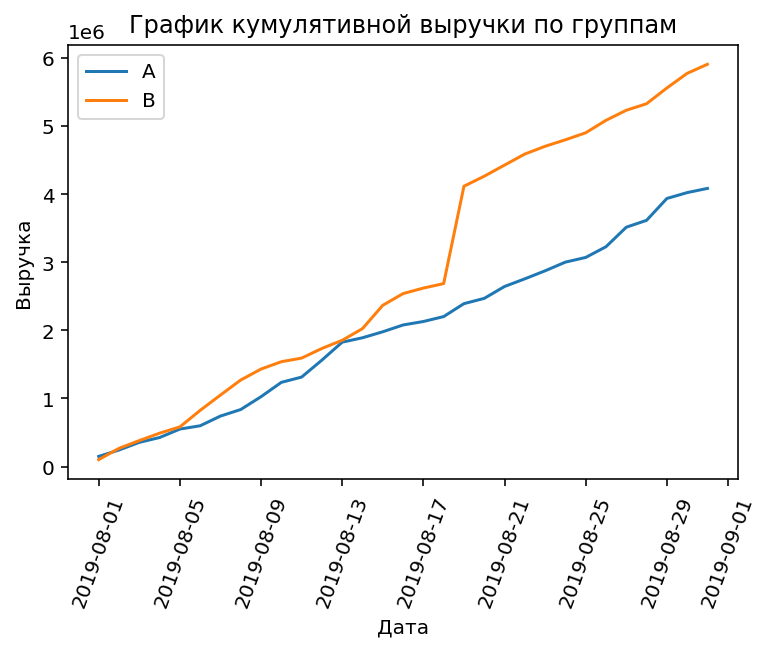

In [23]:
# разделим датафрейм по группам с кумулятивным количеством заказов и кумулятивной выручкой по дням:
cum_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cum_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
# построим график:
plt.plot(cum_revenue_a['date'], cum_revenue_a['revenue'], label='A')
plt.plot(cum_revenue_b['date'], cum_revenue_b['revenue'], label='B')
plt.xticks(rotation=70)
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. 
График выручки группы В 17 августа резко вырос, а затем продолжил рост почти так же равномерно, как и в группе А. Это может говорить о наличии выбросов: крупных по выручке заказов или большого количества заказов в один день.

Построим графики среднего чека для обеих групп.

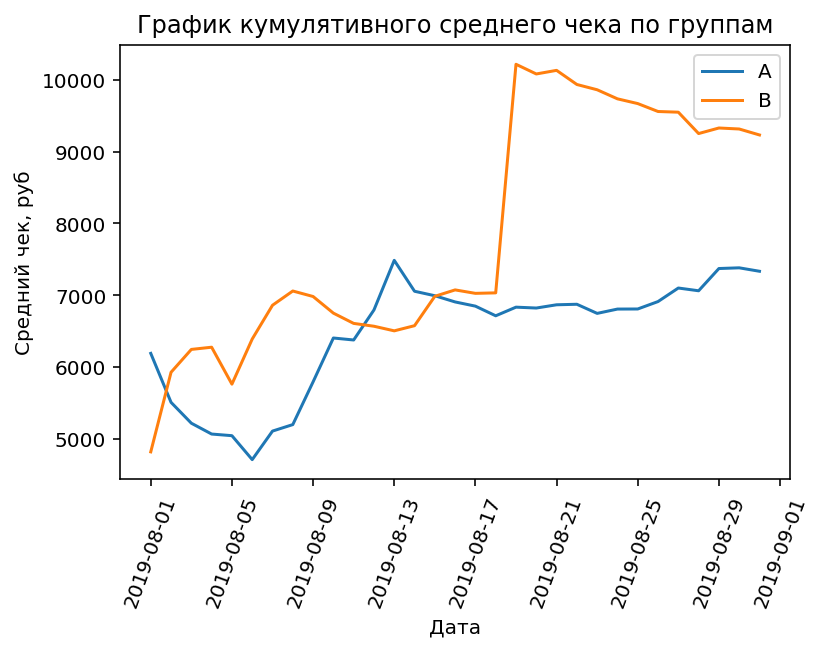

In [24]:
# разделим кумулятивную выручку на кумулятивное число заказов:
plt.plot(cum_revenue_a['date'], cum_revenue_a['revenue']/cum_revenue_a['orders'], label='A')
plt.plot(cum_revenue_b['date'], cum_revenue_b['revenue']/cum_revenue_b['orders'], label='B')
plt.xticks(rotation=70)
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек, руб')
plt.show()

Графики куммулятивного среднего чека для обеих групп стабилизировались лишь во второй половине теста и после аномального выброса. Заметно, что средний чек группы в итоге немного снижается, а группы А медленно растёт.

Рассмотрим график относительного изменения кумулятивного среднего чека группы В к группе А. 

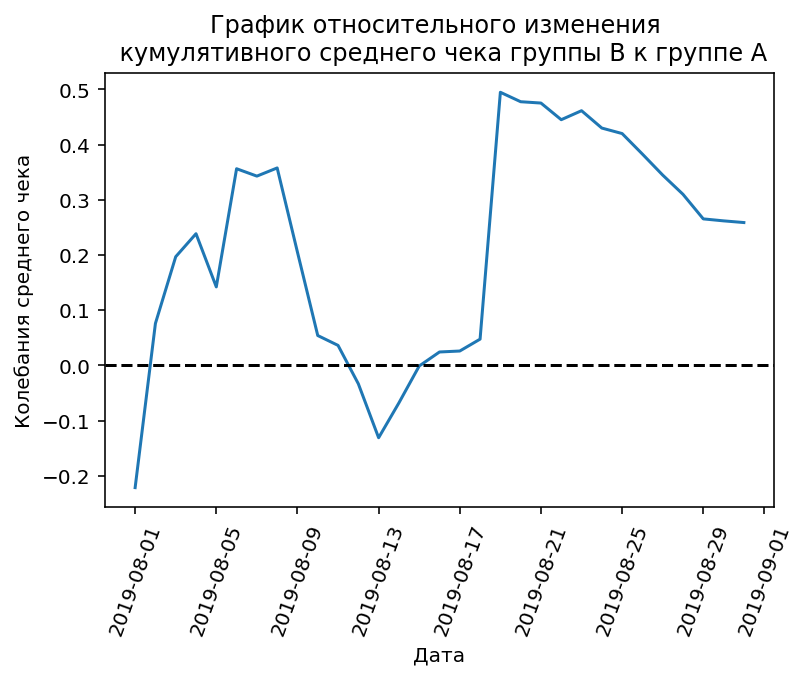

In [25]:
# собираем данные в одном датафрейме:
cum_revenue_all = cum_revenue_a.merge(cum_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
# cтроим график отношения средних чеков:
plt.plot(cum_revenue_all['date'], 
         (cum_revenue_all['revenue_b']/cum_revenue_all['orders_b'])/(cum_revenue_all['revenue_a']/cum_revenue_all['orders_a'])-1
        )
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
# добавим на график корректные подписи
plt.xticks(rotation=70)
plt.title('График относительного изменения \n кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Колебания среднего чека')
plt.show()

Скачки графика в первой половине тестирования объясняются падением среднего чека группы А при росте среднего чека у группы В, визуализированным на предыдущем графике. Проседание ниже нулевой отметки также логичны исходя из графика среднего чека по группам: в этот преиод группа А недолго обгоняла группу В, возможно из-за наличия дорогого заказа в группе А. Последний скачок 19 августа соответствует скачкам на других графиках и говорит о выбросе в данных выручки в группе В.

Построим график кумулятивного среднего количества заказов на посетителя для обеих групп.

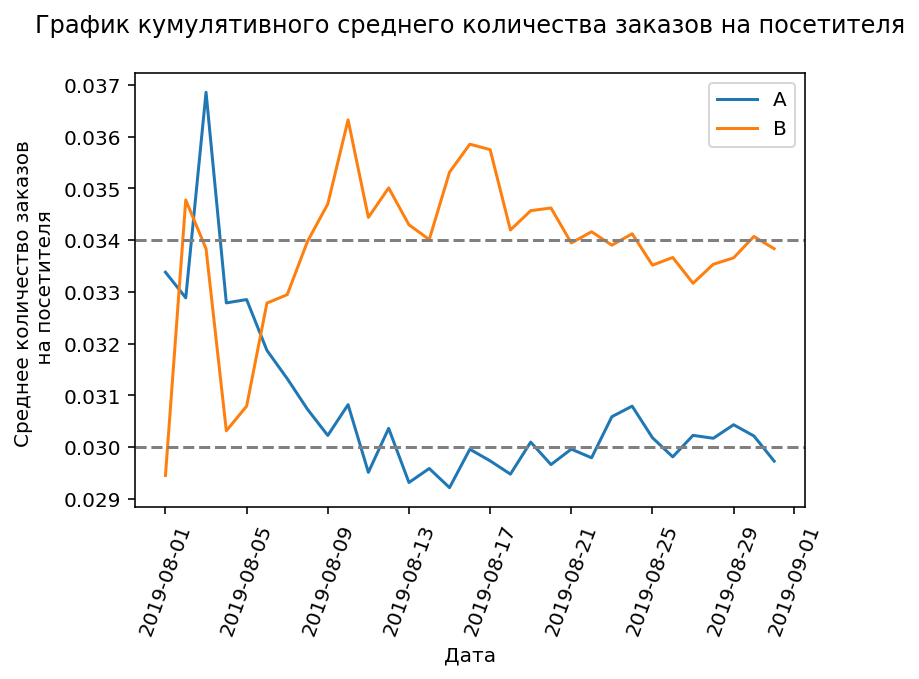

In [26]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
# разделяем данные по группам
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']
# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.axhline(y=0.034, color='grey', linestyle='--')
plt.axhline(y=0.030, color='grey', linestyle='--')
# добавим на график корректные подписи
plt.legend()
plt.xticks(rotation=70)
plt.title('График кумулятивного среднего количества заказов на посетителя\n')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов \n на посетителя')
plt.show()

График довольно симметричный. В начале тестирования группа А лидировала, однако очень скоро показатель среднего количества заказов на посетителя группы В существенно улучшился, в то время как в группе А ситуация сильно ухудшилась. До конца тестирования это значение у группы В осталось большим, по отношению к группе А. Заметна динамика плавного снижения показателя в группе В и такого же плавного роста в группе А. Это говорит о стабилизации метрики во второй половине теста: 0,034 для группы В и 0,030 для группы А.

Рассмотрим график относительного изменения кумулятивного среднего количества заказов на посетителя группы В к группе А.

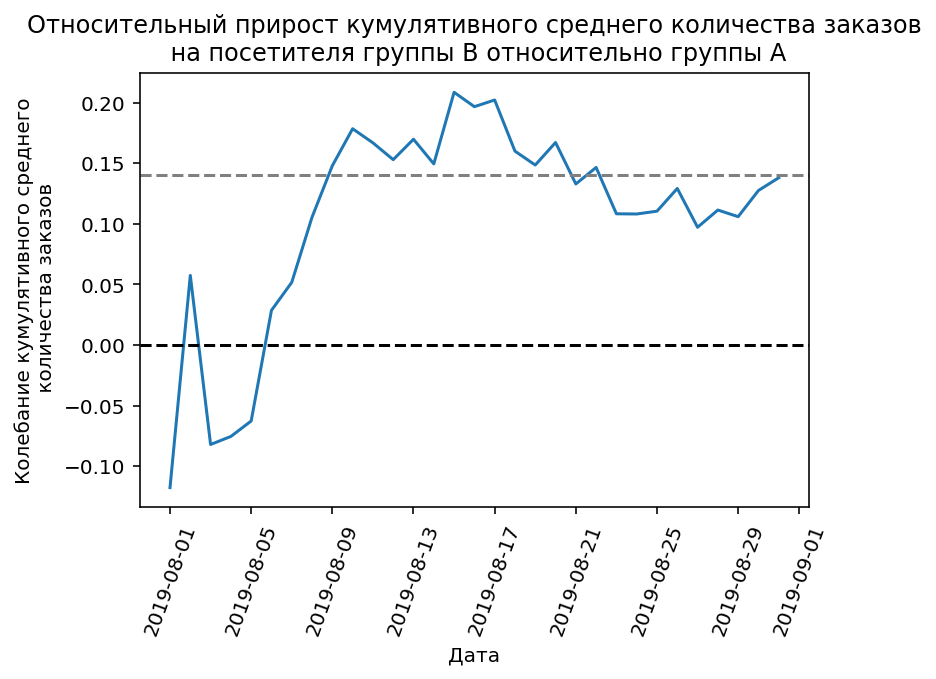

In [27]:
cum_conversoin_all = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['_a', '_b'])

plt.plot(cum_conversoin_all['date'], 
         cum_conversoin_all['conversion_b']/cum_conversoin_all['conversion_a']-1, 
)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')
# добавим на график корректные подписи
plt.title('Относительный прирост кумулятивного среднего количества заказов\n на посетителя группы B относительно группы A')
plt.xticks(rotation=70)
plt.xlabel('Дата')
plt.ylabel('Колебание кумулятивного среднего\n количества заказов')
plt.show()

Группа А в начале теста была лучше по количеству заказов, однако группа В довольно быстро обогнала группу А. С середины тестирования относительный прирост стал снижаться, однако в конце снова показал рост.

**Вывод**

- Анализ кумулятивных метрик (среднего чека и конверсии) позволяет предположить, что в группе B есть экстремально большие по сумме закказы, из-за которых на графиках наблюдается скачок среднего чека и выручки. 
- Конверсия в группах к концу теста стабилизировалась.

### Анализ выбросов

Определим, имели ли место среди постоянных покупателей, совершивших несколько заказов за время тестирования, слишком частые покупки и уточним границы числа заказов.

In [28]:
# сгруппируем таблицу заказов по покупателям и подсчитем их количество:
orders_by_users = (orders.groupby('visitor_id', as_index=False)
                           .agg({'transaction_id': 'nunique'})
                    )

orders_by_users.columns = ['user_id', 'orders_count']

print(orders_by_users.sort_values(by='orders_count', ascending=False).head(20)) 

         user_id  orders_count
1023  4256040402  11          
591   2458001652  11          
569   2378935119  9           
487   2038680547  8           
44    199603092   5           
744   3062433592  5           
55    237748145   5           
917   3803269165  5           
299   1230306981  5           
897   3717692402  5           
393   1614305549  4           
114   457167155   4           
619   2587333274  4           
340   1404934699  3           
937   3908431265  3           
726   2988190573  3           
97    393266494   3           
491   2044997962  3           
677   2780786433  3           
932   3891541246  3           


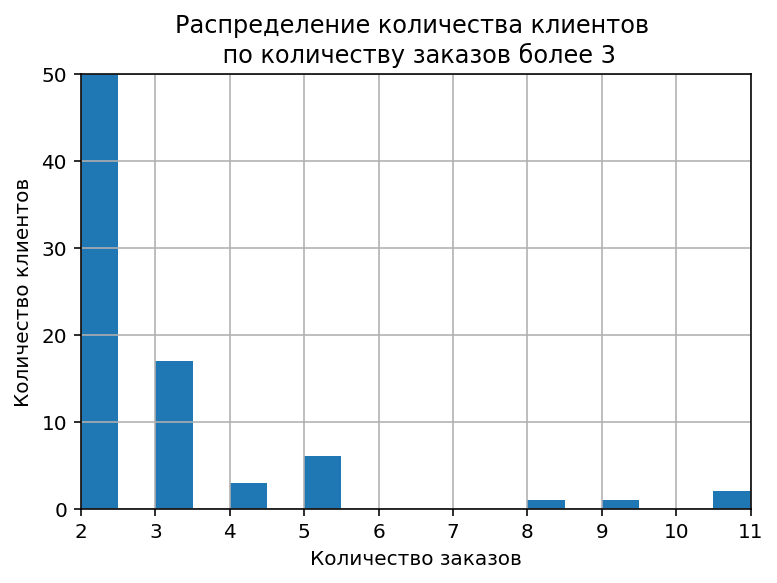

In [29]:
orders_by_users['orders_count'].hist(bins=20)
plt.xlim(2, 11)
plt.ylim(0, 50)
# добавим на график корректные подписи:
plt.title('Распределение количества клиентов \n по количеству заказов более 3')
plt.xlabel('Количество заказов')
plt.ylabel('Количество клиентов')
plt.show()

Большинсво клиентов делали 1заказ. 3 и более заказов уже выглядит малочисленно. Уточним данные по 95 и 99 персентилям.

In [30]:
print(np.percentile(orders_by_users['orders_count'], [95, 99])) 

[2. 4.]


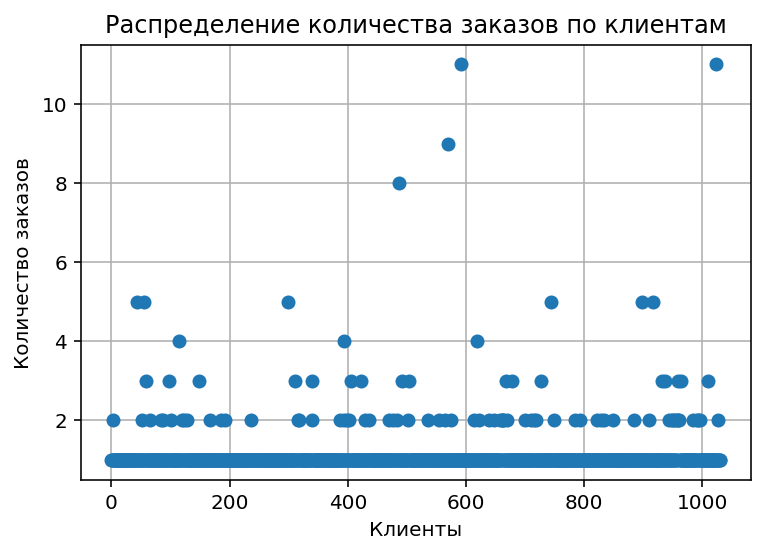

In [31]:
orders_by_users['orders_count'].plot(style='o', grid=True)
plt.xlabel('Клиенты')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов по клиентам')
plt.show()

На точечном графике хорошо заметно, что случаев пяти и более заказов крайне мало. Это же подтверждает гистограмма распределения количесва клиентов по количеству заказов. Согласно расчёту персентилей, 99% пользователей совершили 4 и менее заказов, поэтому клиентов с 5 и более заказами следует считать аномальными и исключить из данных при очистке. 

In [32]:
print('Количество клиентов с большим количеством заказов', len(orders_by_users[orders_by_users['orders_count']>4]))
print('Доля клиентов с большим количеством заказов', round(100*len(orders_by_users[orders_by_users['orders_count']>4])/len(orders_by_users), 2), '%')

Количество клиентов с большим количеством заказов 10
Доля клиентов с большим количеством заказов 0.97 %


Рассмотрим выручку на наличие анмально крупных заказов, которые могли создать скачёк на графиках кумулятивных показателей.

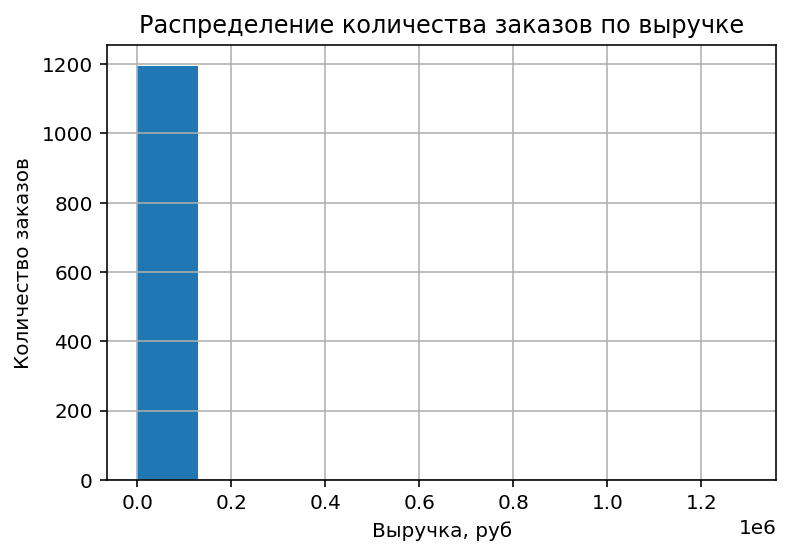

In [33]:
orders['revenue'].hist()
# добавим на график корректные подписи
plt.title('Распределение количества заказов по выручке')
plt.xlabel('Выручка, руб')
plt.ylabel('Количество заказов')
plt.show()

Как и предполагалось, в данных присутствуют выбросы. Рассмотим распределение стимости заказов о оценим количество выбросов. 

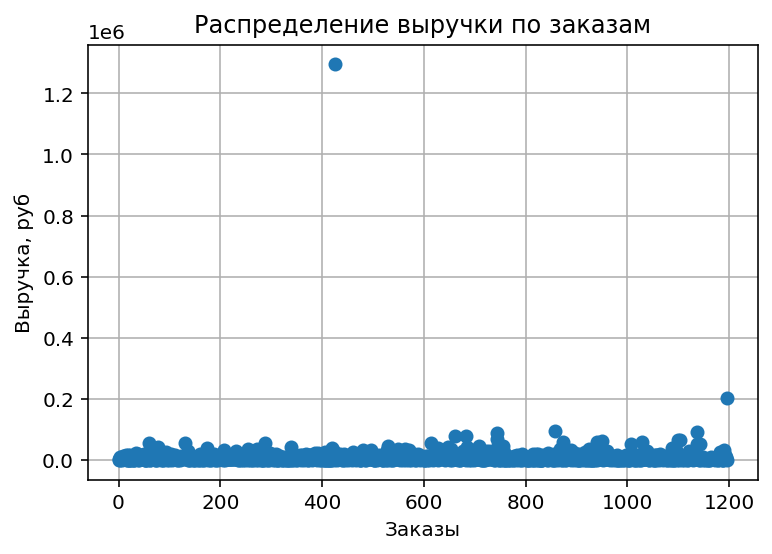

In [34]:
orders['revenue'].plot(style='o', grid=True)
plt.xlabel('Заказы')
plt.ylabel('Выручка, руб')
plt.title('Распределение выручки по заказам')
plt.show()

In [35]:
print(np.percentile(orders['revenue'], [95, 97, 99])) 

[28000.  35485.  58233.2]


In [36]:
print('Количество выбросов', len(orders[orders['revenue']>35000]))
print('Доля выбросов в данных', round(100*len(orders[orders['revenue']>35000])/len(orders), 2), '%')

Количество выбросов 37
Доля выбросов в данных 3.09 %


По полученным данным можно уточнить рабочий диапазон выручки и определить, что заказы с суммой более 35000 руб можно считать аномальными. Этих заказов в данных 37, что составляео примерно 3%. 

### Подсчёт статистической значимости различий в метриках.

Подсчёт статистической значимости различий в метриках сперва проведём на "сырых" (не очищенных от выбросов) данных.

In [37]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [38]:
# создадим таблицы количества пользователей по датам для каждой группы:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_by_date_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_by_date_b']

# подсчитаем кумулятивно количество пользователей в каждый день теста для каждой группы:
cum_visitors_a = cumulative_data[cumulative_data['group']=='A'][['date', 'visitors']].reset_index(drop=True)
cum_visitors_a.columns = ['date', 'visitors_cum_a']

cum_visitors_b = cumulative_data[cumulative_data['group']=='B'][['date', 'visitors']].reset_index(drop=True)
cum_visitors_b.columns = ['date', 'visitors_cum_b']

# создадим таблицы выручки по датам для каждой группы:
orders_a_daily = (orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
                          .groupby('date', as_index=False)
                          .agg({'transaction_id':'nunique', 'revenue':'sum'})
                )
orders_a_daily.columns = ['date', 'orders_by_date_a', 'revenue_by_date_a']

orders_b_daily = (orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
                          .groupby('date', as_index=False)
                          .agg({'transaction_id':'nunique', 'revenue':'sum'})
                )
orders_b_daily.columns = ['date', 'orders_by_date_b', 'revenue_by_date_b']

# создадим таблицы кумулятивной выручки по датам в каждой группе:
cum_orders_a = cumulative_data[cumulative_data['group']=='A'][['date', 'orders', 'revenue']].reset_index(drop=True)
cum_orders_a.columns = ['date', 'orders_cum_a', 'revenue_cum_a']

cum_orders_b = cumulative_data[cumulative_data['group']=='B'][['date', 'orders', 'revenue']].reset_index(drop=True)
cum_orders_b.columns = ['date', 'orders_cum_b', 'revenue_cum_b']


# Объединим все колученные кумулятивные данные в единую таблицу по дате:
data = (orders_a_daily.merge(orders_b_daily, left_on='date', right_on='date', how='left')
                        .merge(cum_orders_a, left_on='date', right_on='date', how='left')
                        .merge(cum_orders_b, left_on='date', right_on='date', how='left')
                        .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
                        .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
                        .merge(cum_visitors_a, left_on='date', right_on='date', how='left')
                        .merge(cum_visitors_b, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,orders_by_date_a,revenue_by_date_a,orders_by_date_b,revenue_by_date_b,orders_cum_a,revenue_cum_a,orders_cum_b,revenue_cum_b,visitors_by_date_a,visitors_by_date_b,visitors_cum_a,visitors_cum_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Подсчитаем статистическую значимость различий в среднем чеке заказа меджу группами по "сырым" данным.

**Сформулируем гипотезы**

*Н0: различий в среднем количестве заказов между группами нет.*

*H1: различия в среднем количестве заказов между группами есть.*

Определим **уровень статистической значимости** в **5%**.

In [39]:
# создадим таблицы количества заказов по пользователям для каждой группы:
orders_by_users_a = (orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False)
                                                    .agg({'transaction_id': pd.Series.nunique})
                    )
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False)
                                                    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

# создадим таблицы, где пользователям из разных групп будет соответствовать количество заказов:
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_by_date_a'].sum() 
                                                                           - len(orders_by_users_a['orders'])
                                                                          ), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_by_date_b'].sum() 
                                                                               - len(orders_by_users_b['orders'])
                                                                              ), name='orders')],axis=0)

In [40]:
def mannwhitneyu(data_a, data_b):
    alpha = 0.05
    p_value = st.mannwhitneyu(data_a, data_b)[1]
    print('Значение p-value составляет', "{0:.5f}".format(p_value))

    if p_value > alpha:
        print('Оставляем нулевую гипотезу:', null)
    else:
        print('Принимаем альтернативную гипотезу:', alternative)
    
    print('Oтносительный прирост показателя группы B составляет', 
      "{0:.2f}".format((data_b.mean() / data_a.mean() - 1)*100), 
      '%')

Проверим гипотезы критерием Манна-Уитни. 

In [41]:
null = 'различий в среднем количестве заказов между группами нет.'
alternative = 'различия в среднем количестве заказов между группами есть.'
mannwhitneyu(sample_a, sample_b)

Значение p-value составляет 0.01679
Принимаем альтернативную гипотезу: различия в среднем количестве заказов между группами есть.
Oтносительный прирост показателя группы B составляет 13.81 %


Проверим статистическую значимость различий в среднем чеке между сегментами. 

*Н0: различий в среднем чеке между группами нет*. 

*Н1: различия в среднем чеке между группами есть*. 

In [42]:
null = 'различий в среднем чеке между группами нет.'
alternative = 'различия в среднем чеке между группами есть.'
mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

Значение p-value составляет 0.72929
Оставляем нулевую гипотезу: различий в среднем чеке между группами нет.
Oтносительный прирост показателя группы B составляет 25.87 %


- Расчитаем показатели статистической значимости различий в очищенных от выбросов данных.

Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 35000 рублей.

In [43]:
anomalusers_count_orders = orders_by_users[orders_by_users['orders_count']>4]['user_id']
print('Количество пользователей с 5 и более заказами', len(anomalusers_count_orders))

anomalusers_revenue_orders = orders[orders['revenue']>35000]['visitor_id']
print('Количество пользователей с заказами более 35000 руб', len(anomalusers_revenue_orders))

anomal_users = (pd.concat([anomalusers_count_orders, anomalusers_revenue_orders], axis=0)
                    .drop_duplicates()
                    .sort_values()
                )
print('Общее количество пользователей с аномальными заказами',len(anomal_users))
print('Доля пользователей с аномальными заказами', round(len(anomal_users)/len(orders['visitor_id'].unique())*100, 2), '%')

Количество пользователей с 5 и более заказами 10
Количество пользователей с заказами более 35000 руб 37
Общее количество пользователей с аномальными заказами 43
Доля пользователей с аномальными заказами 4.17 %


In [44]:
sample_a_filtered = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(anomal_users))]['orders'],
                            pd.Series(0, index=np.arange(data['visitors_by_date_a'].sum() - len(orders_by_users_a['orders'])),
                            name='orders')],
                        axis=0,
)

sample_b_filtered = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(anomal_users))]['orders'],
                            pd.Series(0, index=np.arange(data['visitors_by_date_b'].sum() - len(orders_by_users_b['orders'])),
                            name='orders')],
                        axis=0,
)

In [45]:
null = 'различий в среднем количестве заказов между группами нет.'
alternative = 'различия в среднем количестве заказов между группами есть.'
mannwhitneyu(sample_a_filtered, sample_b_filtered)

Значение p-value составляет 0.01379
Принимаем альтернативную гипотезу: различия в среднем количестве заказов между группами есть.
Oтносительный прирост показателя группы B составляет 15.78 %


In [46]:
orders_a = orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(anomal_users)))]['revenue']
                          
orders_b = orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(anomal_users)))]['revenue']

null = 'различий в среднем чеке между группами нет.'
alternative = 'различия в среднем чеке между группами есть.'
mannwhitneyu(orders_a, orders_b)

Значение p-value составляет 0.87099
Оставляем нулевую гипотезу: различий в среднем чеке между группами нет.
Oтносительный прирост показателя группы B составляет 2.49 %


**Вывод**

Наличие в данных очень крупных чеков и постоянных покупателей, совершающих частые покупки не существенно повлияло на статистические метрики, хотя и ощутимо повысило средний чек группы В. 

По результатам теста на данный момент можно сказать, что различия в группах по среднему чеку нет, но присутствут различие в среднем количестве заказов. Группа В показывает существенный прирост среднего количества заказов (13,81% на "сырых" данных и 15,78% на очищенных).

Относительный прирост показателя среднего чека группы В к группе А после очистки данных от выбросов снизился с 25,87% до 2,49%. Это подтверждает необходимость проверять данные на выбросы. В нашем конкретном случае было удалено 4,17% данных.

## Выводы и рекомендации.

Отдел маркетинга крупного интернет-магазина подготовил список гипотез для увеличения выручки и провёл А/В-тест одной из них.

**Задачи:**
- приоритезирвать гипотезы, применив фреймворк ICE/RICE, и объяснить результат;
- проанализировать результат, принять аргументированное решение об остановке или продолжению теста.

**Описание данных:**
Данные представлены тремя файлами.
Первый файл необходим для приоретизации гипотез и содержит краткое описание гипотезы, охват пользователей, влияние на пользователей, уверенность в гипотезе, затраты ресурсов на проверку гипотезы. Все параметры исчисляются по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
Данные для запуска А/В-теста и его обработки состоят из двух файлов с информацией о заказах пользователей (идентификатор заказа, идентификатор пользователя, дата и выручкой заказа, группа A/B-теста, в которую попал заказ) и информацией о группах А/В-теста (дата, группа A/B-теста, количество пользователей в указанную дату в указанной группе A/B-теста).

На этапе предварительной обработки даннхы были выявлены и исправлены технические ошибки загрузки:
 - в таблице гипотез названия столбцов были приведены к нижнему регистру;
 - в таблице с данными о заказах были изменены названия столбцов и тип данных даты, обнаружены и оставлены без изменения данные постоянных покупателей с несколькими заказами;
 - в таблице с данными о группах тестирования был изменён тип данных столбца даты;
 - в обе группы попали 58 пользователей (6% всего числа клиентов за месяц исследования), которые совершили 181 заказ (15% всего количества заказов) на более 1,5 млн рублей (15,6% выручки). Это существенные доли данных, поэтому их результаты были сохранены.

В процессе приоритезации предложенных гипотез было установлено:
 - лидер по фреймворку RICE - гипотеза 7 ("Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") при подсчёте через фреймворк ICE занимет лишь третью позицию, так как в этом случает не учитывает показатель охвата аудитории. Именно этот параметр существенно поднимет с пятого на второе место гипотезу 2 ("Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"), так как охват у этой гипотезы существенно шире - можно предположить, что рекомендации посмотрят почти все пользователи сайта. А вот гипотеза 8 о запуске акции, дающую скидку на товар в день рождения, которая хоть и затрагивает всех пользователей, но не сразу и это опускает её с лидирующей позиции при проверке ICE на пятое место в списке RICE;


 - наименее приоритетны в обоих случаях проверки гипотезы об изменеии фона главной страницы, гипотеза о добавлении отзывов, гипотеза об изменеии структуры категорий. Гипотеза о запуске собственной службы достваки также не получила высоких приоритетов по обоим фремворкам ввиду наибольшей трудоёмкости.


**Рекомендации:**

1) Если ранжирование гипотез должно включать в себя охват пользователей интернет-магазина, то гипотезы следует рассматривать в следующей последовательности:

- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
- "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить средний чек заказа"
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"

2) Если охват пользователей не важен, из предоставленного списка следует в первую очередь обратить внимание на гипотезы:

- "Запустить акцию, дающую скидку на товар в день рождения"
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"


Анализ результатов А/В-теста:

- Есть статистически значимое различие по среднему количеству заказов на клиента между группами как по «сырым», так и по очищенным от аномалий данным.  Группа В показывает существенный прирост среднего количества заказов (13,81% на "сырых" данных и 15,78% на очищенных).

- График относительного прироста кумулятивного среднего количества заказов на посетителя группы B относительно группы A подтверждает, что группа В довольно быстро обогнала группу А. С середины тестирования относительный прирост стал меньше, однако в конце снова показал рост.

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по очищенным от аномалий данным. Относительный прирост показателя среднего чека группы В к группе А после очистки данных от выбросов снизился с 25,87% до 2,49%, но остался положительным.

**Рекомендации:**

- тест следует принять успешным;
- рекомендуется остановить тест, зафиксировав победу группы В, так как средние показатели группы В стабильно выше средних группы А;
- поработать с обнаруженными постоянными клиентами: они могли бы быть анкетированы или опрошены о том, как сильно повлияло на них анализируемое изменение. Результаты такого опроса можно было бы приложить к итоговой презентации.